# See Whether Molecular Dynamics Works
We want to make sure that molecular dynamics with our new model still produces reasonable structures

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from schnetpack.interfaces.ase_interface import SpkCalculator
from fff.simulation import run_calculator
from fff.simulation.md import run_dynamics
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.calculators.psi4 import Psi4
from ase.db import connect
from tqdm import tqdm
import numpy as np
import warnings
import torch

/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configure the DFT methods

In [2]:
dft_kwargs = dict(method='b3lyp-d3', basis='6-31g')

## Get a starting structure
Just a random structure to start with

In [3]:
with connect('../initial-database/initial-psi4.db') as db:
    atoms = next(db.select('', limit=1)).toatoms()
atoms

Atoms(symbols='H42O21', pbc=False, calculator=SinglePointCalculator(...))

## Make the SchNet and Psi4 Calculators
We're going to compare their performance

In [4]:
%%time
psi4_calc = Psi4(**dft_kwargs, num_threads=12)
psi4_eng = psi4_calc.get_potential_energy(atoms)

  Threads set to 12 by Python driver.
  Threads set to 12 by Python driver.


/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/psi4/driver/procrouting/empirical_dispersion.py:212: FutureWarning: Using the `local_options` keyword argument is deprecated in favor of using `task_config`, in version 0.30.0 it will stop working.
  jobrec = qcng.compute(


CPU times: user 3min 15s, sys: 3.16 s, total: 3min 18s
Wall time: 20.1 s


In [5]:
spk_calc = SpkCalculator(torch.load('starting-psi4-model', map_location='cpu'), energy='energy', forces='forces')
spk_eng = spk_calc.get_potential_energy(atoms)

In [6]:
print(f'Energy of starting geom - Psi4: {psi4_eng:.1f}, SchNet: {spk_eng:.1f} eV')

Energy of starting geom - Psi4: -43667.9, SchNet: -43661.1 eV


Off by a few eV, but that's OK for now as we have yet to train this model

## Check whether MD with the SchNet Model produces reasonable structures
The energies don't have to be accurate, it just has to make reasonable structures

In [7]:
%%time
MaxwellBoltzmannDistribution(atoms, temperature_K=50)
traj = run_dynamics(atoms, spk_calc, timestep=0.1, steps=100, log_interval=10)

CPU times: user 8.08 s, sys: 108 ms, total: 8.19 s
Wall time: 682 ms


Get the energies using Psi4

In [8]:
spk_energies = [a.get_potential_energy() for a in traj]

In [9]:
psi4_energies = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for a in tqdm(traj):
        try:
            psi4_eng = psi4_calc.get_potential_energy(a)
        except BaseException:
            psi4_eng = np.nan
        psi4_energies.append(psi4_eng)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [03:09<00:00, 17.21s/it]


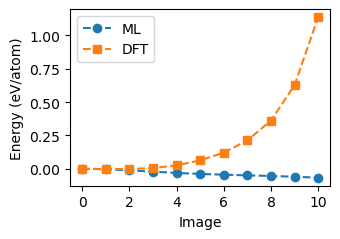

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(np.subtract(spk_energies, spk_energies[0]) / len(atoms), '--o', label='ML')
ax.plot(np.subtract(psi4_energies, psi4_energies[0]) / len(atoms), '--s', label='DFT')

ax.set_xlabel('Image')
ax.set_ylabel('Energy (eV/atom)')

ax.legend()
fig.tight_layout()

We start off with pretty similar energies, but they rapidly diverge after many timesteps.